In [1]:
#Imports
import sys
sys.path.append('../../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('../data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (list(a) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1 = np.asarray(v_err1)
#Express as weights
weighdata = 1/v_err1

In [3]:
#keeping others but holding them constant
def f(r,h,d_rho00,rc,h_rho00):
     return np.sqrt(nf.bh_v(r,load=True,path='../')**2 
                    + nf.h_v(r,rc,h_rho00,load=True,path='../')**2 
                    + nf.b_v(r,load=True,path='../')**2 
                    + nf.d_v(r,h,d_rho00,load=True,path='../')**2)
#Only Black Hole and Halo
def d_h(r,h,d_rho00,rc,h_rho00):
    return np.sqrt(nf.d_v(r,h,d_rho00,load=True,path='../')**2 + nf.h_v(r,rc,h_rho00,load=True,path='../')**2)

In [4]:
#Fit, Keeping rest constant

#Setup
l_mod = lm.Model(f)
l_params = l_mod.make_params()
#Disk Params
l_params.add('h', value=nf.h_c, min=0)
l_params.add('d_rho00', value=nf.drho00_c, min=0) #Density (disk)
#Halo
l_params.add('rc', value=nf.h_rc, min=0)   #Radius (magnitude)
l_params.add('h_rho00', value=nf.hrho00_c, min=0) #Density (halo)
#Do fit
l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

In [5]:
#Fit, D and H only

#Setup
dh_mod = lm.Model(d_h)
dh_params = dh_mod.make_params()
#Disk Params
dh_params.add('h', value=nf.h_c, min=0)
dh_params.add('d_rho00', value=nf.drho00_c, min=0) #Density (disk)
#Halo
dh_params.add('rc', value=nf.h_rc, min=0)   #Radius (magnitude)
dh_params.add('h_rho00', value=nf.hrho00_c, min=0) #Density (halo)
#Do fit
dh_fit = dh_mod.fit(v_dat,dh_params,r=r_dat,weights=weighdata)

In [6]:
#Define curves to plot

l_dict = l_fit.best_values
l_h = l_dict['h']
l_d_rho00 = l_dict['d_rho00']
l_rc = l_dict['rc']
l_h_rho00 = l_dict['h_rho00']
l_curve = f(r_dat,l_h,l_d_rho00,l_rc,l_h_rho00)

dh_dict = dh_fit.best_values
dh_h = dh_dict['h']
dh_d_rho00 = dh_dict['d_rho00']
dh_rc = dh_dict['rc']
dh_h_rho00 = dh_dict['h_rho00']

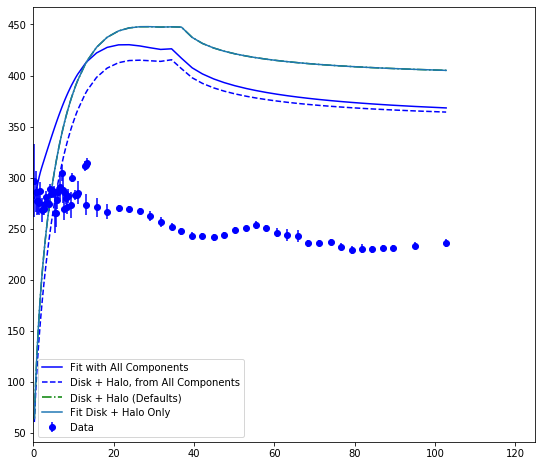

Fit information for single-component fit


In [7]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,125)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='Fit with All Components')
plt.plot(r_dat,d_h(r_dat,l_h,l_d_rho00,l_rc,l_h_rho00),'b--',label='Disk + Halo, from All Components')
plt.plot(r_dat,d_h(r_dat,nf.h_c,nf.drho00_c,nf.h_rc,nf.hrho00_c),'g-.',label='Disk + Halo (Defaults)')
plt.plot(r_dat,d_h(r_dat,dh_h,dh_d_rho00,dh_rc,dh_h_rho00),label='Fit Disk + Halo Only')

plt.legend()
plt.show()

print('Fit information for single-component fit')
l_fit

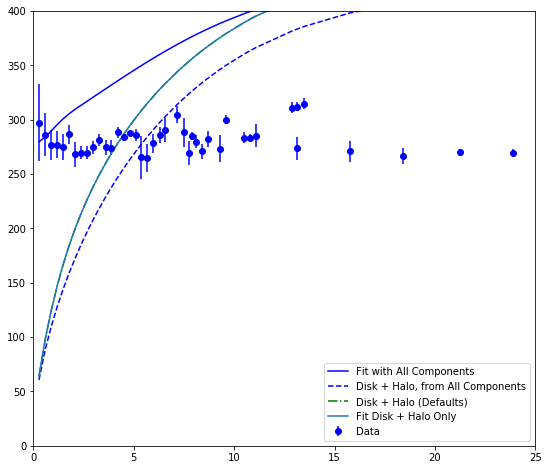

Fit information for two-component fit


In [8]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)
plt.ylim(0,400)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='Fit with All Components')
plt.plot(r_dat,d_h(r_dat,l_h,l_d_rho00,l_rc,l_h_rho00),'b--',label='Disk + Halo, from All Components')
plt.plot(r_dat,d_h(r_dat,nf.h_c,nf.drho00_c,nf.h_rc,nf.hrho00_c),'g-.',label='Disk + Halo (Defaults)')
plt.plot(r_dat,d_h(r_dat,dh_h,dh_d_rho00,dh_rc,dh_h_rho00),label='Fit Disk + Halo Only')

plt.legend()
plt.show()

print('Fit information for two-component fit')
dh_fit

In [9]:
endtime = t.time()
print('Total Time:')
print(str(endtime - starttime)+' seconds')
print('')

print('Timestamp:')
print(datetime.now())

Total Time:
0.939154863357544 seconds

Timestamp:
2019-10-16 15:18:40.402309


Total time listed above is inaccurate. I ran this for three days and it did not finish. (Most recent attempt April 2020.)